In [1]:
import os, gc, torch

import numpy as np
import pandas as pd
from models.load import TrainedModels

from utils.eval import save_iou_results
from utils.engine import xami_evaluate
from models.load import get_trained_model
from utils.coco_eval import get_eval_params_dict
from data.dataset import ReflacxDataset, OurRadiologsitsDataset
from utils.data import get_datasets, get_dataloaders
from data.dataset import collate_fn
from utils.transforms import get_transform
from our_radiologist.load import get_anns
from utils.coco_eval import get_ar_ap
from utils.print import print_title

## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
gc.collect()
# torch.cuda.memory_summary(device=None, abbreviated=False)

use_gpu = torch.cuda.is_available()
device = 'cuda' if use_gpu else 'cpu'
print(f"This notebook will running on device: [{device}]")

if use_gpu:
    torch.cuda.empty_cache()

This notebook will running on device: [cuda]


In [3]:
XAMI_MIMIC_PATH =  "D:\XAMI-MIMIC"

labels_cols = [
    "Enlarged cardiac silhouette",
    "Atelectasis",
    "Pleural abnormality",
    "Consolidation",
    "Pulmonary edema",
    #  'Groundglass opacity', # 6th disease.
]

normal_iou_thrs = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

all_range_iou_thrs = np.array(
        [
            0.00,
            0.05,
            0.1,
            0.15,
            0.2,
            0.25,
            0.3,
            0.35,
            0.4,
            0.45,
            0.5,
            0.55,
            0.6,
            0.65,
            0.7,
            0.75,
            0.8,
            0.85,
            0.9,
            0.95,
            1.0,
        ]
    )

In [4]:
select_model = TrainedModels.overfitting

In [5]:
model, train_info = get_trained_model(
    select_model, labels_cols, device, include_train_info=True
)
model.eval()

dataset_params_dict = {
    "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
    "with_clinical": train_info.model_setup.use_clinical,
    "dataset_mode": "unified",
    "bbox_to_mask": True,
    "labels_cols": [
        "Enlarged cardiac silhouette",
        "Atelectasis",
        "Pleural abnormality",
        "Consolidation",
        "Pulmonary edema",
        #  'Groundglass opacity', # 6th disease.
    ],
}


detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
    dataset_params_dict=dataset_params_dict
)

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
    train_dataset, val_dataset, test_dataset, batch_size=4
)

radiologists_ann = get_anns("radiologists_annotated", detect_eval_dataset)
radiologist_dataset = OurRadiologsitsDataset(detect_eval_dataset, radiologists_ann)
radiologist_dataloader = torch.utils.data.DataLoader(
    radiologist_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn,
)

normal_eval_params_dict = get_eval_params_dict(
    detect_eval_dataset, iou_thrs=normal_iou_thrs,
)

all_range_eval_params_dict = get_eval_params_dict(
    detect_eval_dataset, iou_thrs=all_range_iou_thrs,
)

model.roi_heads.score_thresh = 0.05

all_cat_ids = [None] + [
    detect_eval_dataset.disease_to_idx(d) for d in detect_eval_dataset.labels_cols
]

for cat_id in all_cat_ids:
    cat_ids = (
        [detect_eval_dataset.disease_to_idx(d) for d in detect_eval_dataset.labels_cols]
        if cat_id is None
        else [cat_id]
    )
    if not (cat_ids is None):
        normal_eval_params_dict["bbox"].catIds = cat_ids
        normal_eval_params_dict["segm"].catIds = cat_ids

    train_evaluator = xami_evaluate(
        model,
        train_dataloader,
        device=device,
        params_dict=normal_eval_params_dict,
        # score_thres=score_thres,
    )

    test_evaluator = xami_evaluate(
        model,
        test_dataloader,
        device=device,
        params_dict=normal_eval_params_dict,
        # score_thres=score_thres,
    )

    val_evaluator = xami_evaluate(
        model,
        val_dataloader,
        device=device,
        params_dict=normal_eval_params_dict,
        # score_thres=score_thres,
    )

    radiologist_evaluator = xami_evaluate(
        model,
        radiologist_dataloader,
        device=device,
        params_dict=normal_eval_params_dict,
    )

    if cat_id is None:
        disease_str = "all"
    else:
        disease_str = detect_eval_dataset.label_idx_to_disease(cat_id)

    train_ar, train_ap = get_ar_ap(train_evaluator, areaRng="all", maxDets=10, iouThr=None)
    test_ar, test_ap = get_ar_ap(test_evaluator, areaRng="all", maxDets=10, iouThr=None)
    val_ar, val_ap = get_ar_ap(val_evaluator, areaRng="all", maxDets=10, iouThr=None)
    our_ar, our_ap = get_ar_ap(
        radiologist_evaluator, areaRng="all", maxDets=10, iouThr=None
    )

    df = pd.DataFrame(
        [
            {
                "dataset": "test",
                f"AP@[IoBB = 0.50:0.95]": test_ap,
                f"AR@[IoBB = 0.50:0.95]": test_ar,
            },
            {
                "dataset": "val",
                f"AP@[IoBB = 0.50:0.95]": val_ap,
                f"AR@[IoBB = 0.50:0.95]": val_ar,
            },
            {
                "dataset": "our",
                f"AP@[IoBB = 0.50:0.95]": our_ap,
                f"AR@[IoBB = 0.50:0.95]": our_ar,
            },
            {
                "dataset": "train",
                f"AP@[IoBB = 0.50:0.95]": train_ap,
                f"AR@[IoBB = 0.50:0.95]": train_ar,
            },
        ]
    )

    df.to_csv(os.path.join("eval_results", f"{select_model.value}_{disease_str}.csv"))
    print_title(disease_str)
    print(df)

for cat_id in all_cat_ids:

    cat_ids = (
        [detect_eval_dataset.disease_to_idx(d) for d in detect_eval_dataset.labels_cols]
        if cat_id is None
        else [cat_id]
    )
    if not (cat_ids is None):
        all_range_eval_params_dict["bbox"].catIds = cat_ids
        all_range_eval_params_dict["segm"].catIds = cat_ids

    train_evaluator = xami_evaluate(
        model,
        train_dataloader,
        device=device,
        params_dict=all_range_eval_params_dict,
        # score_thres=score_thres,
    )

    test_evaluator = xami_evaluate(
        model,
        test_dataloader,
        device=device,
        params_dict=all_range_eval_params_dict,
        # score_thres=score_thres,
    )

    val_evaluator = xami_evaluate(
        model,
        val_dataloader,
        device=device,
        params_dict=all_range_eval_params_dict,
        # score_thres=score_thres,
    )

    radiologist_evaluator = xami_evaluate(
        model,
        radiologist_dataloader,
        device=device,
        params_dict=all_range_eval_params_dict,
    )

    if cat_id is None:
        disease_str = "all"
    else:
        disease_str = detect_eval_dataset.label_idx_to_disease(cat_id)

    save_iou_results(train_evaluator, f"train_{disease_str}", select_model.value)
    save_iou_results(test_evaluator, f"test_{disease_str}", select_model.value)
    save_iou_results(val_evaluator, f"val_{disease_str}", select_model.value)
    save_iou_results(radiologist_evaluator, f"our_{disease_str}", select_model.value)


creating index...
index created!
creating index...
index created!
creating index...
index created!
Test:  [  0/104]  eta: 0:15:12  model_time: 7.6623 (7.6623)  evaluator_time: 0.4012 (0.4012)  time: 8.7718  data: 0.5800  max mem: 1111
Test:  [100/104]  eta: 0:00:04  model_time: 0.1251 (0.2125)  evaluator_time: 0.0927 (0.1265)  time: 0.9681  data: 0.6509  max mem: 1401
Test:  [103/104]  eta: 0:00:01  model_time: 0.1250 (0.2095)  evaluator_time: 0.0881 (0.1243)  time: 0.9256  data: 0.6272  max mem: 1401
Test: Total time: 0:01:55 (1.1138 s / it)
Averaged stats: model_time: 0.1250 (0.2095)  evaluator_time: 0.0881 (0.1243)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoBB=0.50:0.95 | area=   all | maxDets=100 ] = 0.378
 Average Precision  (AP) @[ IoBB=0.50      | area=   all | maxDets= 10 ] = 0.482
 Average Precision  (AP) @[ IoBB=0.75      | area=   all | maxDets= 10 ] = 0.358
 Average Pre

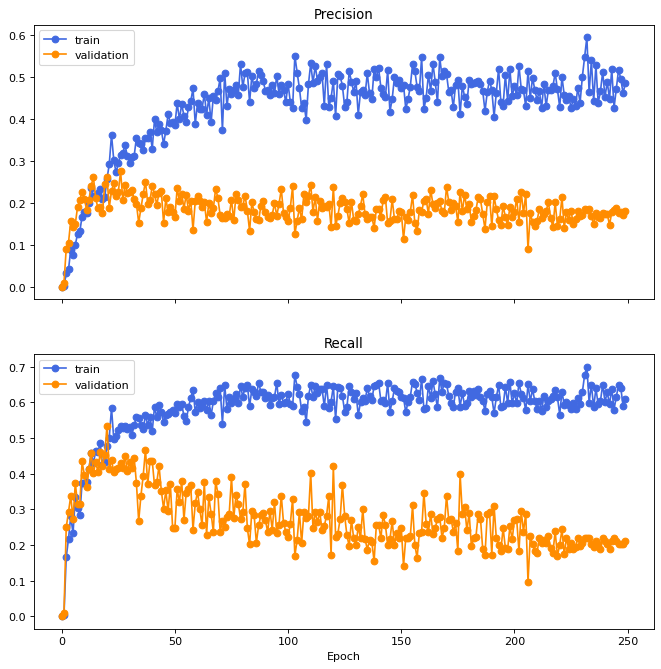

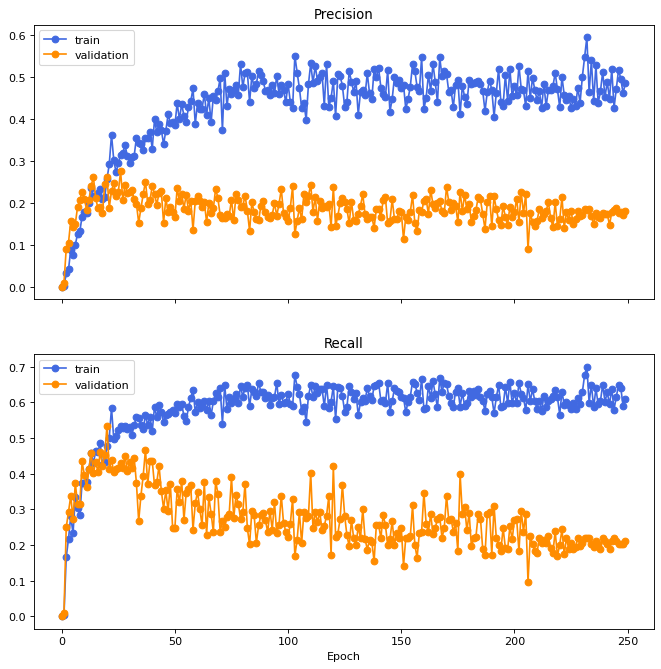

In [6]:
from utils.plot import plot_train_val_evaluators

plot_train_val_evaluators(
    train_info.train_evaluators,
    train_info.val_evaluators,
    areaRng="all",
    iouThr=0.5,
    maxDets=10,
)



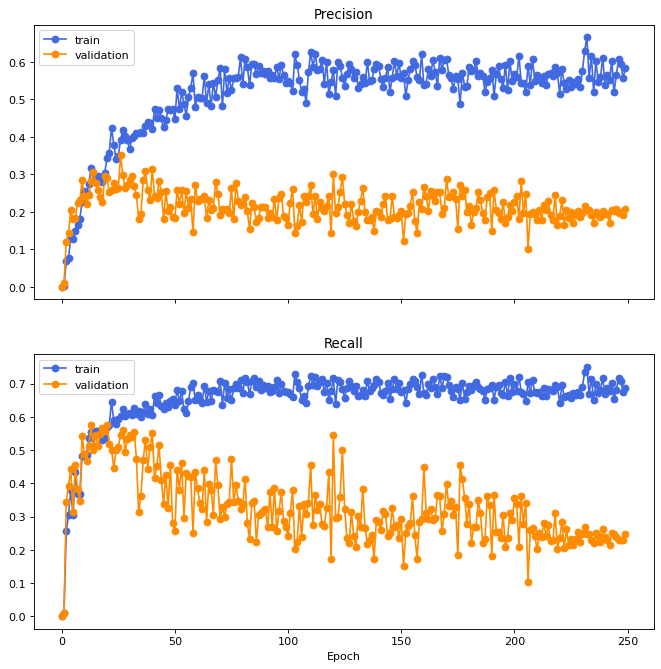

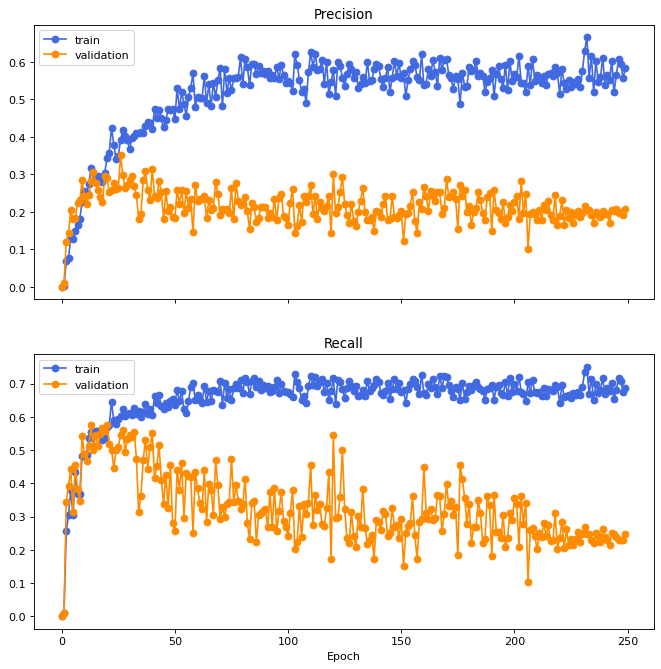

In [14]:
plot_train_val_evaluators(
    train_info.train_evaluators,
    train_info.val_evaluators,
    areaRng="all",
    iouThr=0.25,
    maxDets=10,
)

,dataset,ar,ap
0,train,0.629937,0.497549
1,val,0.246866,0.206076
2,test,0.298677,0.171414
3,our,0.242857,0.189142


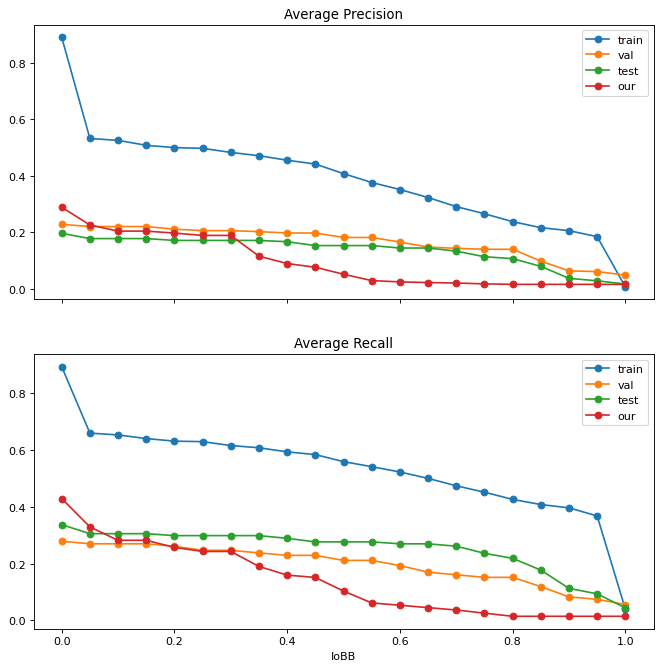

In [19]:
import pickle

from IPython.display import display
import matplotlib.pyplot as plt

thrs = 0.25

all_datasets = ['train', 'val', 'test', 'our']
 
disease = 'all'

all_dataset_eval_data = {}
for dataset in all_datasets:
    with open(
        os.path.join(
            "eval_results",
            f"{select_model.value}_{dataset}_{disease}.pkl",
        ),
        "rb",
    ) as f:
        eval_data = pickle.load(f)
        all_dataset_eval_data[dataset] = eval_data


fig, (precision_ax, recall_ax) = plt.subplots(
    2, figsize=(10, 10), dpi=80, sharex=True,
)


display(
    pd.DataFrame(
        [
            {
                "dataset": dataset,
                **all_dataset_eval_data[dataset][thrs][0],
            } for dataset in all_datasets
        ]
    )
)

precision_ax.set_title("Average Precision")

for dataset in all_dataset_eval_data:
    precision_ax.plot(
        all_dataset_eval_data[dataset].keys(),
        [v[0]["ap"] for v in all_dataset_eval_data[dataset].values()],
        marker="o",
        label=dataset,
        # color="darkorange",
    )
precision_ax.legend(loc="upper right")

recall_ax.set_title("Average Recall")
for dataset in all_dataset_eval_data:
    recall_ax.plot(
        all_dataset_eval_data[dataset].keys(),
        [v[0]["ar"] for v in all_dataset_eval_data[dataset].values()],
        marker="o",
        label=dataset,
        # color="darkorange",
    )

recall_ax.legend(loc="upper right")
recall_ax.set_xlabel("IoBB")

plt.plot()
plt.pause(0.01)
